In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
#//import pandas as pd

#//df = pd.read_csv("D:/RFMiD_Original_Vit/RFMiD/RFMiD_Training_Labels.csv")

#//column_names = df.columns

#//print(column_names)

In [4]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['Bacterialblight',
               'Blast',
               'Brown Spot',
               'Hispa',
               'Leaf smut',
               'Rice__healthy']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [5]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [6]:
# Setup directory paths to train and test images
train_dir = "D:/Mega Project/rice_leaf_diseases_dataset/Training_set"
test_dir = "D:/Mega Project/rice_leaf_diseases_dataset/Test_set"

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [7]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [8]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [9]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..1.9428324].


torch.Size([3, 224, 224]) tensor(4)


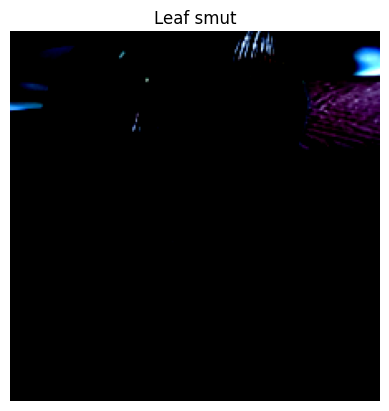

In [11]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader_pretrained))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [12]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5051 | train_acc: 0.8368 | test_loss: 1.0462 | test_acc: 0.7543
Epoch: 2 | train_loss: 0.2393 | train_acc: 0.9331 | test_loss: 1.0971 | test_acc: 0.7815
Epoch: 3 | train_loss: 0.1817 | train_acc: 0.9513 | test_loss: 1.2054 | test_acc: 0.7838
Epoch: 4 | train_loss: 0.1535 | train_acc: 0.9553 | test_loss: 1.2406 | test_acc: 0.7895
Epoch: 5 | train_loss: 0.1334 | train_acc: 0.9608 | test_loss: 1.2816 | test_acc: 0.7883
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9639 | test_loss: 1.3377 | test_acc: 0.7917
Epoch: 7 | train_loss: 0.1138 | train_acc: 0.9653 | test_loss: 1.3763 | test_acc: 0.7924
Epoch: 8 | train_loss: 0.1040 | train_acc: 0.9681 | test_loss: 1.4208 | test_acc: 0.7924
Epoch: 9 | train_loss: 0.0998 | train_acc: 0.9694 | test_loss: 1.4711 | test_acc: 0.7945
Epoch: 10 | train_loss: 0.0963 | train_acc: 0.9694 | test_loss: 1.4780 | test_acc: 0.7906


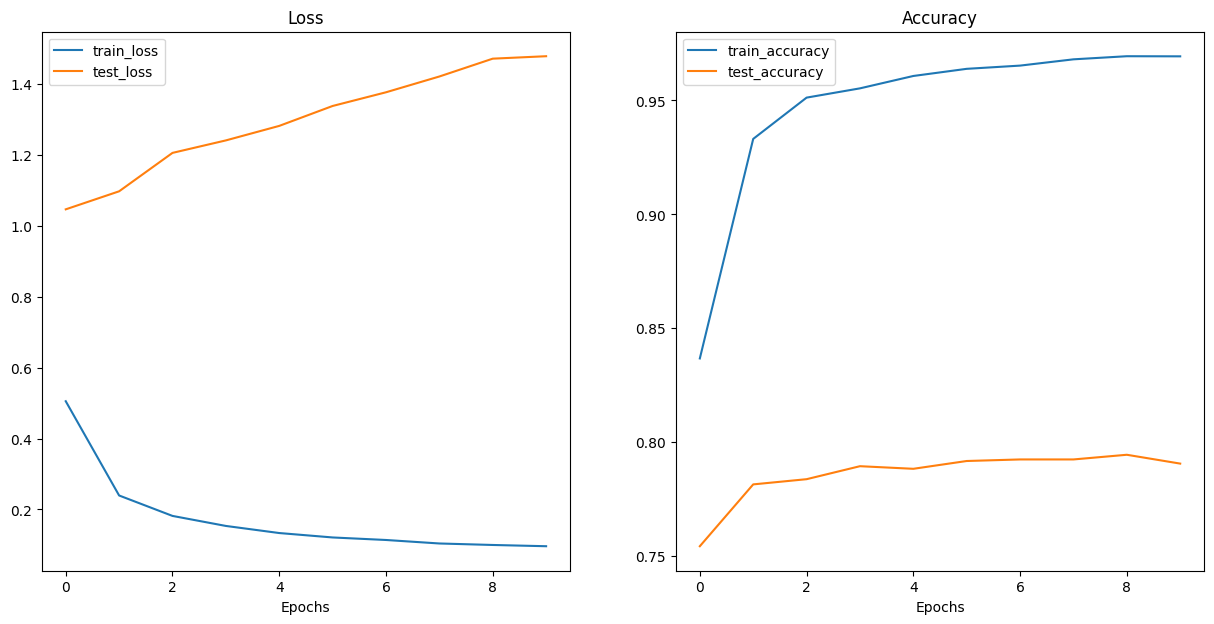

In [75]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


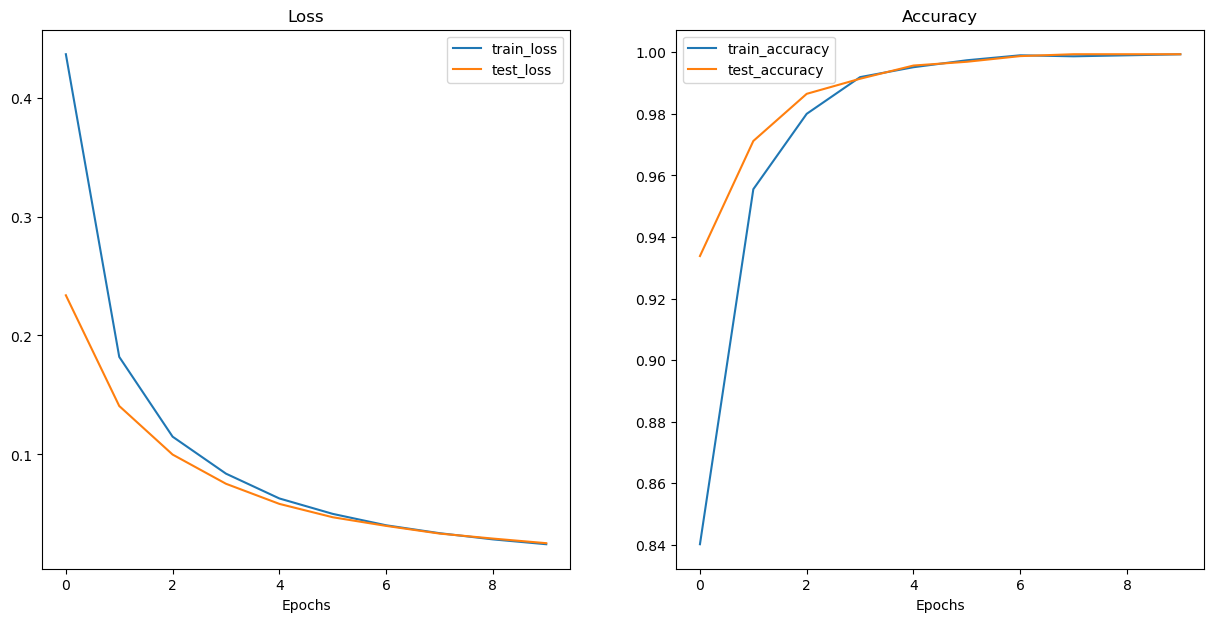

In [12]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

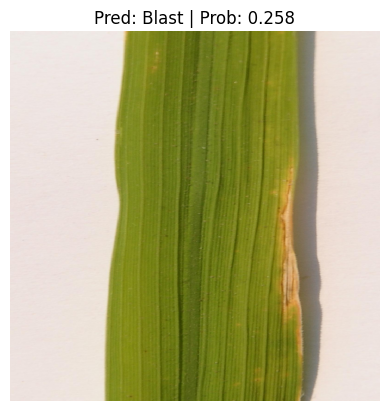

In [12]:
"""
Utility functions to make predictions.

Main reference for code creation: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set 
"""
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)
    

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Let's make Prediction:

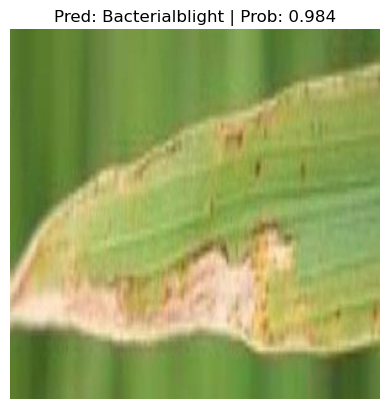

In [48]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "C:/Users/Asus/Desktop/Mega Project/validation/BACTERIALBLIGHT2.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

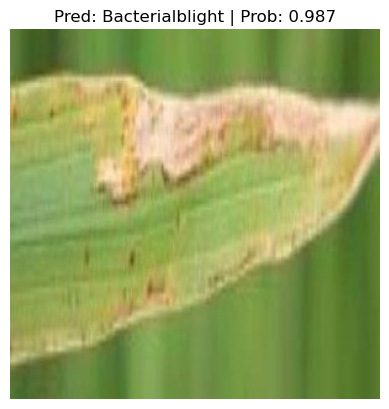

In [43]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "C:/Users/Asus/Desktop/Mega Project/validation/BACTERIALBLIGHT3.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

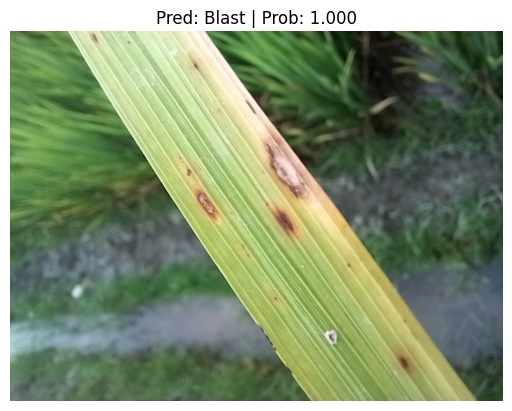

In [80]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "D:/Mega Project/rice_leaf_diseases_dataset/Training_set/Blast/20231006_165845(0).jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

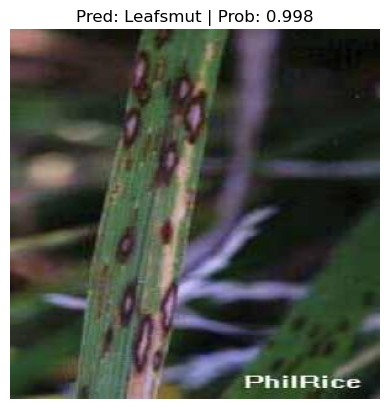

In [38]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "C:/Users/Asus/Desktop/Mega Project/validation/BLAST2.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

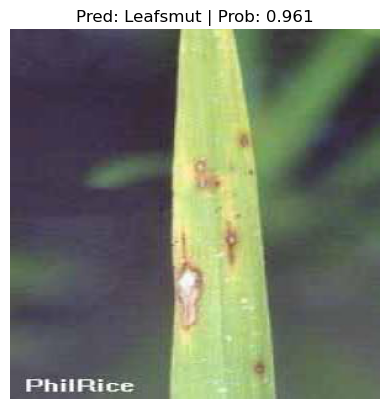

In [51]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "C:/Users/Asus/Desktop/Mega Project/validation/BLAST3.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

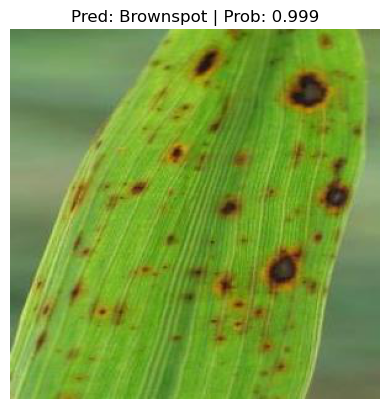

In [45]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "C:/Users/Asus/Desktop/Mega Project/validation/brownspot_orig_2.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

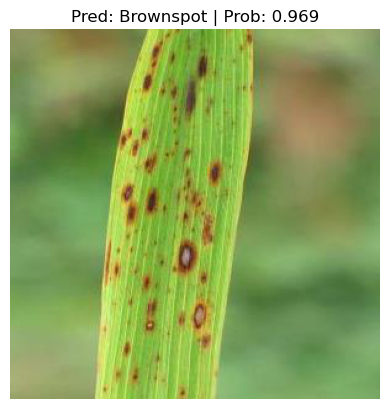

In [50]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "C:/Users/Asus/Desktop/Mega Project/validation/brownspot_orig_3.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

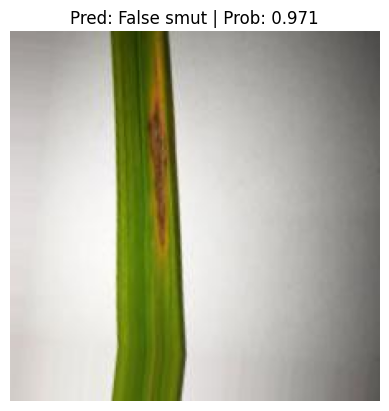

In [37]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "D:/Mega Project/rice_leaf_diseases_dataset/Training_set/Blast/aug_0_2471.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [16]:
# Save the trained model
torch.save(pretrained_vit.state_dict(), 'path_to_save_pretrained_model.pth')

In [10]:
MODEL_PATH = 'path_to_save_pretrained_model.pth'
model = torch.load(MODEL_PATH, weights_only=True)

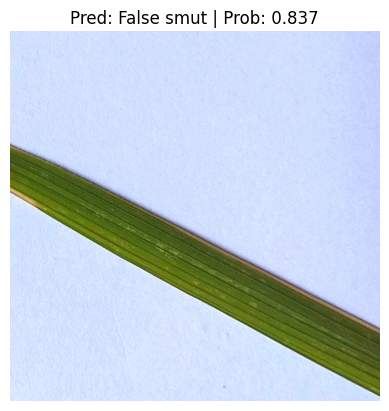

In [38]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "D:/Mega Project/rice_leaf_diseases_dataset/Test_set/Hispa/IMG_20190419_114834.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

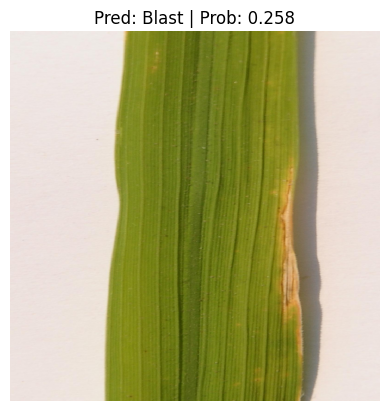

In [11]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "D:/Mega Project/rice_leaf_diseases_dataset/Test_set/Bacterialblight/bacterial_leaf_blight (1).JPG"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

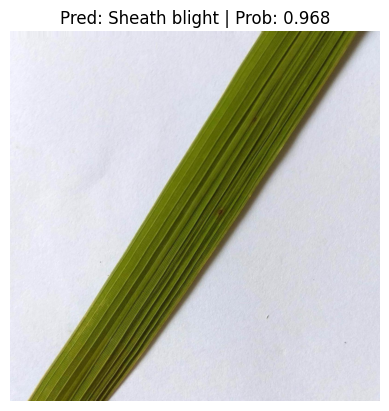

In [32]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "D:/Mega Project/rice_leaf_diseases_dataset/Training_set/Rice__healthy/healthy19.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

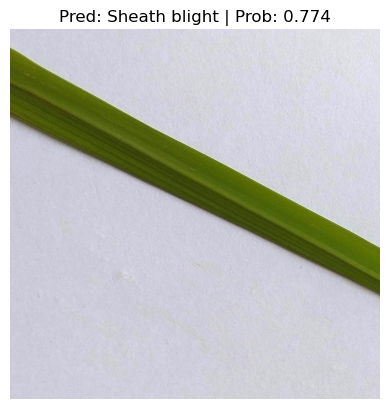

In [57]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "D:/Mega Project/rice_leaf_diseases_dataset/Test_set/Rice__healthy/healthy (150).jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [13]:
"""
Utility functions to make predictions.

Main reference for code creation: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set 
"""
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple  # Make sure List and Tuple are imported

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Updated function to return class label, probability, and image path
def get_pred_label_prob_and_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
) -> Tuple[str, float, str]:
    """Predicts on a target image and returns class label, probability, and image path.

    Args:
        model (torch.nn.Module): A trained PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to the target image.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.

    Returns:
        Tuple[str, float, str]: Predicted class label, its probability, and the image path.
    """
    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Get predicted class label and probability
    target_image_pred_label_idx = torch.argmax(target_image_pred_probs, dim=1).item()
    target_image_pred_label = class_names[target_image_pred_label_idx]
    target_image_pred_prob = target_image_pred_probs[0][target_image_pred_label_idx].item()

    return target_image_pred_label, target_image_pred_prob, image_path


# Example usage:
# Ensure you have `pretrained_vit`, `class_names`, and `custom_image_path` defined
class_label, class_prob, img_path = get_pred_label_prob_and_image(
    model=pretrained_vit,
    class_names=class_names,
    image_path=custom_image_path
)

# Now you can access `class_label`, `class_prob`, and `img_path` separately
print(f"Class: {class_label}, Probability: {class_prob:.3f}, Image Path: {img_path}")

# Setting the disease name and probability
Disease = class_label
Probability = class_prob


Class: Blast, Probability: 0.258, Image Path: D:/Mega Project/rice_leaf_diseases_dataset/Test_set/Bacterialblight/bacterial_leaf_blight (1).JPG


In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib

# Load the pre-trained Random Forest model
rf_model = joblib.load('D:/Mega Project/RandomForest PKL/random_forest_model.pkl')

# Load the dataset to get the original feature names used in training
data = pd.read_excel('D:/Mega Project/Rice_CSV_Dataset/Copy of Vidhi_Crop_Disease_Dataset_of_hackthon_updated.xlsx')

# Remove the 'Diseases' column from the original feature names
original_feature_names = data.drop(columns=['Diseases']).columns.tolist()

# Prepare the real-time input data (only Temperature and Humidity)
real_time_input = {
    'Temperature': 24.5,  # in degree Celsius
    'Humidity': 93,  # in percentage
}

# Fill missing features with default values (0 or a reasonable default)
real_time_filled_input = {feature: real_time_input.get(feature, 0) for feature in original_feature_names}

# Convert the filled input into a DataFrame
real_time_df = pd.DataFrame([real_time_filled_input])

# Identify numerical and categorical columns
numerical_cols = ['Temperature', 'Humidity']  # Update with actual numerical columns
categorical_cols = ['Crop', 'Organism', 'Infection_State', 'Etiology1', 'Etiology2', 'Etiology3', 'primary Infection', 'Secondary Infection']  # Replace with actual categorical columns

# Apply standard scaling on numerical features
scaler = StandardScaler()
real_time_df[numerical_cols] = scaler.fit_transform(real_time_df[numerical_cols])

# Apply one-hot encoding on categorical features (if needed)
real_time_df = pd.get_dummies(real_time_df, columns=categorical_cols)

# Align the columns with the training model
for col in original_feature_names:
    if col not in real_time_df.columns:
        real_time_df[col] = 0  # Fill missing columns with 0

# Reorder the DataFrame to match the training model's feature order
real_time_df = real_time_df[original_feature_names]

# Predict using the Random Forest model
rf_pred_prob = rf_model.predict_proba(real_time_df)
rf_pred_class = rf_model.predict(real_time_df)

# Ensemble predictions from Vision Transformer and Random Forest

Disease = class_label;
Probability = class_prob;

vit_output = {
    'Disease': Disease,  # Example output from ViT
    'Probability': Probability  # Example probability from ViT
}

alpha = 0.8  # Weight for Vision Transformer output
rf_prob = rf_pred_prob[0][np.argmax(rf_pred_class)]

# Combine predictions using a weighted average
final_prob = (alpha * vit_output['Probability']) + ((1 - alpha) * rf_prob)
final_prediction = vit_output['Disease']  # Since the disease labels are the same

# Final ensemble output
ensemble_output = {
    'Disease': final_prediction,
    'Final Probability': final_prob
}

print("Ensemble Prediction:", ensemble_output)

# Create a dataset row to store predictions and features
output_row = {
    'Image': custom_image_path,  # Replace with actual image path
    'Disease_Predicted': final_prediction,
    'Final_Probability': final_prob,
    'Temperature': real_time_input['Temperature'],
    'Humidity': real_time_input['Humidity'],
}

# Append to CSV or database
output_df = pd.DataFrame([output_row])
output_df.to_csv('predicted_diseases.csv', mode='a', header=False, index=False)

print("Stored output to predicted_diseases.csv")


Ensemble Prediction: {'Disease': 'Blast', 'Final Probability': 0.20862691593170168}
Stored output to predicted_diseases.csv


In [19]:
data.columns.tolist()

['Crop',
 'Diseases',
 'Humidity',
 'Temperature',
 'Organism',
 'Infection_State',
 'Etiology1',
 'Etiology2',
 'Etiology3',
 'primary Infection',
 'Secondary Infection']

In [20]:
data.columns.tolist()

['Crop',
 'Diseases',
 'Humidity',
 'Temperature',
 'Organism',
 'Infection_State',
 'Etiology1',
 'Etiology2',
 'Etiology3',
 'primary Infection',
 'Secondary Infection']

In [15]:
# Load the dataset
data = pd.read_excel('D:/Mega Project/Rice_CSV_Dataset/Copy of Vidhi_Crop_Disease_Dataset_of_hackthon_updated.xlsx')

# Identify categorical columns (usually of type 'object' or 'category')
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

print("Categorical columns:", categorical_cols)


Categorical columns: ['Crop', 'Diseases', 'Organism', 'Infection_State', 'Etiology1', 'Etiology2', 'Etiology3', 'primary Infection', 'Secondary Infection']


# Control and Management (Fetch information through Database runs on XAMPP)

In [16]:
import mysql.connector

# Connect to the MySQL database in XAMPP
def get_prevention_and_symptom(disease_name):
    try:
        # Establish the connection to the database
        connection = mysql.connector.connect(
            host='localhost',      # XAMPP default host
            user='root',           # Default user for XAMPP
            password='',           # Leave it empty if no password is set for root user
            database='rice_prevention'  # Your database name
        )

        if connection.is_connected():
            cursor = connection.cursor()

            # SQL query to fetch disease prevention based on disease_name
            prevention_query = "SELECT disease_prevention FROM pest_control WHERE disease_name = %s"
            cursor.execute(prevention_query, (disease_name,))
            
            # Fetch the disease prevention result
            prevention_result = cursor.fetchone()

            # SQL query to fetch symptom based on disease_name
            symptom_query = "SELECT Symptom FROM pest_control WHERE disease_name = %s"
            cursor.execute(symptom_query, (disease_name,))
            
            # Fetch the symptom result
            symptom_result = cursor.fetchone()

            # Display the results
            if prevention_result:
                print(f"Prevention for {disease_name}: {prevention_result[0]}")
            else:
                print(f"No prevention found for {disease_name}")
            
            if symptom_result:
                print(f"Symptom for {disease_name}: {symptom_result[0]}")
            else:
                print(f"No symptom found for {disease_name}")

    except mysql.connector.Error as e:
        print(f"Error connecting to MySQL: {e}")

    finally:
        # Close the database connection
        if connection.is_connected():
            cursor.close()
            connection.close()

# Take user input for disease name
disease_name_input = class_label  # class_labelYou can change this to user input or any other disease
get_prevention_and_symptom(disease_name_input)


Prevention for Blast: Plant resistant varieties, apply balanced fertilization, and maintain proper water levels.
Symptom for Blast: All aboveground parts of the rice plant (leaves, leaf collar, culm, culm nodes, neck, and panicle) are attacked by the fungus
initial symptoms are white to gray-green lesions or spots with brown borders
Small specks originate on leaves - subsequently enlarge into spindle shaped spots(0.5 to 1.5cm length, 0.3 to 0.5cm width) with ashy center.  
older lesions elliptical or spindle-shaped and whitish to gray with necrotic borders Several spots coalesce to  form big irregular patches.
nodal infection causes the culm to break at the infected node
Internodal infection also occurs at the base of the plant which causes white panicles similar to that induced by yellow stem borer or water deficit
Lesions on the neck are grayish brown and causes the girdling of the neck and the panicle to fall over
If infection of the neck occurs before milk stage, no grain is formed

Accuracy: 97.37%

Classification Report:
                        precision    recall  f1-score   support

            Collar rot       1.00      1.00      1.00         3
            False smut       0.00      0.00      0.00         1
             Leaf smut       1.00      1.00      1.00         1
           Orange leaf       1.00      1.00      1.00         6
     Rice Yellow Dwarf       1.00      1.00      1.00         3
         Sheath blight       1.00      1.00      1.00         1
      Sheath brown rot       1.00      1.00      1.00         4
              Stem Rot       1.00      1.00      1.00         1
                Stripe       1.00      1.00      1.00         4
       Stripe necrosis       1.00      1.00      1.00         1
     White leaf streak       1.00      1.00      1.00         2
         Yellow mottle       1.00      1.00      1.00         1
       bakanae disease       1.00      1.00      1.00         4
             foot root       1.00      1.00      1.00         

C:\Users\Farhan Khan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Farhan Khan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Farhan Khan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


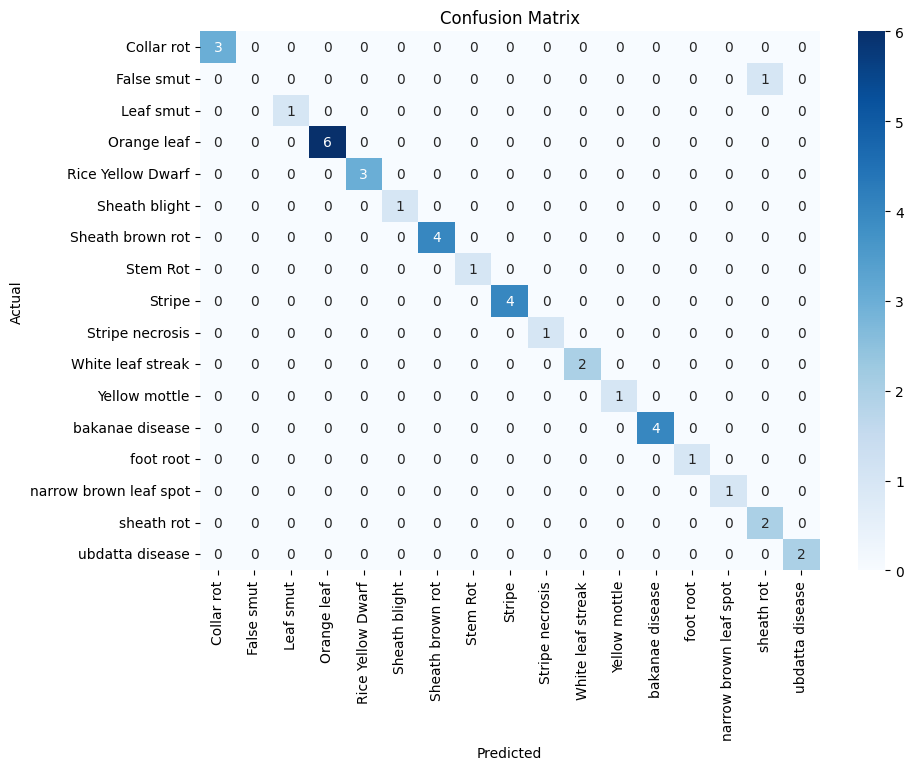

<Figure size 640x480 with 0 Axes>

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_excel('D:/Mega Project/Rice_CSV_Dataset/Copy of Vidhi_Crop_Disease_Dataset_of_hackthon_updated.xlsx')

# Feature and target variables
X = df.drop(columns=['Diseases'])
y = df['Diseases']

# Identify numerical columns to scale
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Apply standard scaling on numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Apply ordinal encoding on categorical features
ordinal_encoder = OrdinalEncoder()
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])

# Encode target variable (diseases)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Get the unique labels in the test set and corresponding class names
unique_labels = np.unique(y_test)
class_names = le.inverse_transform(unique_labels)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Optionally save the confusion matrix plot
plt.savefig('confusion_matrix.png')


In [36]:
import os
from tkinter import Tk, filedialog, Label, Button
from PIL import Image, ImageTk
import torch
from typing import List, Tuple

# Assuming the `get_pred_label_prob_and_image` function is already defined as provided.

# Define constants
device = "cuda" if torch.cuda.is_available() else "cpu"
class_names = [
    'Bacterialblight', 'Blast', 'Brown Spot', 'Hispa',
    'Leaf smut', 'narrow brown leaf spot', 'Rice__healthy',
    'Sheath blight', 'Tungro'
]

# Assuming `pretrained_vit` is the trained Vision Transformer model already loaded in the environment.

# Initialize Tkinter
root = Tk()
root.title("Crop Disease Detection")
root.geometry("500x500")

# Define GUI components
def select_and_predict():
    global img_label, result_label
    # Select an image
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.png;*.jpeg")])

    if file_path:
        # Display the image
        img = Image.open(file_path)
        img.thumbnail((250, 250))
        img_tk = ImageTk.PhotoImage(img)

        if img_label is not None:
            img_label.destroy()  # Remove previous image if exists
        img_label = Label(root, image=img_tk)
        img_label.image = img_tk
        img_label.pack()

        try:
            # Get prediction results using the provided utility function
            class_label, class_prob, img_path = get_pred_label_prob_and_image(
                model=pretrained_vit,
                class_names=class_names,
                image_path=file_path,
                device=device
            )

            # Setting the disease name and probability
            Disease = class_label
            Probability = class_prob

            # Display results
            result_text = f"Disease: {Disease}\nProbability: {Probability:.3f}"
            if result_label is not None:
                result_label.destroy()  # Remove previous results if exists
            result_label = Label(root, text=result_text, font=("Helvetica", 14))
            result_label.pack()
        except Exception as e:
            # Display error message
            result_text = f"Prediction failed. Error: {str(e)}"
            if result_label is not None:
                result_label.destroy()
            result_label = Label(root, text=result_text, font=("Helvetica", 14), fg="red")
            result_label.pack()

# Initialize global variables
img_label = None
result_label = None

# Add a button to select image and predict
btn_select = Button(root, text="Select Image & Predict", command=select_and_predict)
btn_select.pack(pady=20)

# Run Tkinter loop
root.mainloop()


In [52]:
code = ''' 
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
import streamlit as st
import random

# Set random seeds for reproducibility
def set_seeds(seed_value=42):
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Step 1: Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Step 2: Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Step 3: Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Step 4: Change the classifier head
class_names = [
    'Bacterialblight', 'Blast', 'Brown Spot', 'Hispa',
    'Leaf smut', 'narrow brown leaf spot', 'Rice__healthy',
    'Sheath blight', 'Tungro'
]
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Set model to evaluation mode
pretrained_vit.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prediction function
def get_pred_label_prob_and_image(model, class_names, image_path, device):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image)  # Model output
        if outputs.size(1) != len(class_names):
            raise ValueError(f"Model output does not match the number of class names: "
                             f"{outputs.size(1)} != {len(class_names)}")
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        class_idx = torch.argmax(probabilities, dim=1).item()
        prob = probabilities[0][class_idx].item()
    
    # Return predicted class and probability
    return class_names[class_idx], prob, image_path

# Streamlit App
st.set_page_config(page_title="Crop Disease Detection", page_icon="🌾", layout="centered")

# Add custom CSS for styling
st.markdown(
    """
    <style>
    body {
        background-color: #f5f5f5;
        color: #333;
    }
    .stButton > button {
        background-color: #4CAF50;
        color: white;
        font-size: 16px;
        padding: 10px 20px;
        border-radius: 8px;
        transition: all 0.3s ease;
    }
    .stButton > button:hover {
        background-color: #45a049;
    }
    .title {
        font-size: 40px;
        font-weight: bold;
        text-align: center;
        color: #4CAF50;
    }
    .response-box {
        margin-top: 20px;
        background-color: #2b2b2b;
        color: #ffffff;
        padding: 15px;
        border-radius: 10px;
    }
    </style>
    """,
    unsafe_allow_html=True
)

# Header
st.markdown('<h1 class="title">Crop Disease Detection 🌾</h1>', unsafe_allow_html=True)

# Upload image file
uploaded_file = st.file_uploader("Upload an image of the crop:", type=["jpg", "png", "jpeg"])

if uploaded_file:
    # Display uploaded image
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Prediction button
    if st.button("Predict Disease"):
        with st.spinner('Predicting...'):
            try:
                # Call the prediction function
                class_label, class_prob, img_path = get_pred_label_prob_and_image(
                    model=pretrained_vit,
                    class_names=class_names,
                    image_path=uploaded_file,
                    device=device
                )
                # Display results
                st.markdown(
                    f"""
                    <div class="response-box">
                        <h3>Prediction Results:</h3>
                        <p><strong>Disease:</strong> {class_label}</p>
                        <p><strong>Probability:</strong> {class_prob:.3f}</p>
                    </div>
                    """,
                    unsafe_allow_html=True
                )
            except Exception as e:
                st.error(f"Prediction failed. Error: {str(e)}")

# Footer
st.markdown("<p style='text-align: center; color: gray;'>© 2024 Crop Disease Detection App</p>", unsafe_allow_html=True)


'''

# Saving the code with UTF-8 encoding
with open("streamlit_app.py", "w", encoding="utf-8") as file:
    file.write(code)


In [18]:
code = ''' 
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
import streamlit as st
import random
import mysql.connector  # For MySQL integration

# Set random seeds for reproducibility
def set_seeds(seed_value=42):
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Step 1: Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Step 2: Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Step 3: Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Step 4: Change the classifier head
class_names = [
    'Bacterialblight', 'Blast', 'Brown Spot', 'Hispa',
    'Leaf smut', 'narrow brown leaf spot', 'Rice__healthy',
    'Sheath blight', 'Tungro'
]
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Set model to evaluation mode
pretrained_vit.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prediction function
def get_pred_label_prob_and_image(model, class_names, image_path, device):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image)  # Model output
        if outputs.size(1) != len(class_names):
            raise ValueError(f"Model output does not match the number of class names: "
                             f"{outputs.size(1)} != {len(class_names)}")
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        class_idx = torch.argmax(probabilities, dim=1).item()
        prob = probabilities[0][class_idx].item()
    
    # Return predicted class and probability
    return class_names[class_idx], prob, image_path

# Function to get prevention and symptom information from MySQL
def get_prevention_and_symptom(disease_name):
    try:
        # Establish the connection to the database
        connection = mysql.connector.connect(
            host='localhost',
            user='root',
            password='',
            database='rice_prevention'
        )

        if connection.is_connected():
            cursor = connection.cursor()

            # SQL query to fetch disease prevention and symptoms
            prevention_query = "SELECT disease_prevention FROM pest_control WHERE disease_name = %s"
            cursor.execute(prevention_query, (disease_name,))
            prevention_result = cursor.fetchone()

            symptom_query = "SELECT Symptom FROM pest_control WHERE disease_name = %s"
            cursor.execute(symptom_query, (disease_name,))
            symptom_result = cursor.fetchone()

            return prevention_result[0] if prevention_result else None, symptom_result[0] if symptom_result else None

    except mysql.connector.Error as e:
        st.error(f"Error connecting to MySQL: {e}")
        return None, None

    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()

# Streamlit App
st.set_page_config(page_title="Crop Disease Detection", page_icon="🌾", layout="centered")

# Add custom CSS for styling
st.markdown(
    """
    <style>
    body {
        background-color: #f5f5f5;
        color: #333;
    }
    .stButton > button {
        background-color: #4CAF50;
        color: white;
        font-size: 16px;
        padding: 10px 20px;
        border-radius: 8px;
        transition: all 0.3s ease;
    }
    .stButton > button:hover {
        background-color: #45a049;
    }
    .title {
        font-size: 40px;
        font-weight: bold;
        text-align: center;
        color: #4CAF50;
    }
    .response-box {
        margin-top: 20px;
        background-color: #2b2b2b;
        color: #ffffff;
        padding: 15px;
        border-radius: 10px;
    }
    </style>
    """,
    unsafe_allow_html=True
)

# Header
st.markdown('<h1 class="title">Crop Disease Detection 🌾</h1>', unsafe_allow_html=True)

# Upload image file
uploaded_file = st.file_uploader("Upload an image of the crop:", type=["jpg", "png", "jpeg"])

if uploaded_file:
    # Display uploaded image
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Prediction button
    if st.button("Predict Disease"):
        with st.spinner('Predicting...'):
            try:
                # Call the prediction function
                class_label, class_prob, img_path = get_pred_label_prob_and_image(
                    model=pretrained_vit,
                    class_names=class_names,
                    image_path=uploaded_file,
                    device=device
                )
                prevention, symptom = get_prevention_and_symptom(class_label)

                # Display results
                st.markdown(
                    f"""
                    <div class="response-box">
                        <h3>Prediction Results:</h3>
                        <p><strong>Disease:</strong> {class_label}</p>
                        <p><strong>Probability:</strong> </p>
                        <p><strong>Prevention:</strong> {prevention if prevention else "No prevention data available."}</p>
                        <p><strong>Symptom:</strong> {symptom if symptom else "No symptom data available."}</p>
                    </div>
                    """,
                    unsafe_allow_html=True
                )
            except Exception as e:
                st.error(f"Prediction failed. Error: {str(e)}")

# Footer
st.markdown("<p style='text-align: center; color: gray;'>© 2024 Crop Disease Detection App</p>", unsafe_allow_html=True)

'''

# Saving the code with UTF-8 encoding
with open("streamlit_app.py", "w", encoding="utf-8") as file:
    file.write(code)


In [ ]:
!streamlit run streamlit_app.py --server.port=8501